#### Análisis y Procesamiento de Señales

---

# Tarea Semanal N°5
## *Estimación espectral: Ancho de banda de señales reales*

#### Augusto Colugnatti - Mateo Murgia

---

## Introducción teórica 

En este trabajo se busca **estimar el ancho de banda efectivo de señales reales** mediante distintos métodos de **estimación espectral de potencia**.  
El objetivo es comparar los resultados obtenidos para diferentes tipos de señales (electrocardiográficas (ECG), fotopletismográficas (PPG) y de audio) aplicando técnicas que permiten analizar su **contenido frecuencial** y determinar el rango donde se concentra la **mayor parte de su energía**.

---

### Densidad espectral de potencia (PSD)

La **densidad espectral de potencia (Power Spectral Density, PSD)** describe cómo se distribuye la potencia promedio de una señal en función de la frecuencia.

De acuerdo con Holton, para una señal discreta estacionaria ( $ x[n] $ ), la PSD teórica se define como la **Transformada Discreta de Fourier (DTFT)** de su función de autocorrelación $ r_{xx}[m] $:

\begin{equation}
S_{xx}(f) = \sum_{m=-\infty}^{\infty} r_{xx}[m] \, e^{-j 2\pi f m}
\end{equation}

donde

\begin{equation}
r_{xx}[m] = E\{x[n] \, x^*[n+m]\}
\end{equation}

En la práctica, las señales disponibles son finitas, por lo que se utilizan **estimadores** que aproximan $ S_{xx}(f) $ a partir de los datos temporales, considerando una relación de compromiso entre el **sesgo** y la **varianza**.

---

### Métodos de estimación espectral

Según Holton, los métodos pueden clasificarse en:

1. **No paramétricos**, que no suponen un modelo estadístico de la señal, sean los métodos de periodograma, Welch y Blackman–Tukey.
2. **Paramétricos**, que suponen un modelo AR, MA o ARMA.

En este trabajo se emplean únicamente los métodos no paramétricos.

---

### 1. Periodograma simple

El **periodograma** estima la PSD a partir de la DFT de una señal finita de **N muestras**:

\begin{equation}
\hat{S}_{xx}(f_k) = \frac{1}{N} |X(f_k)|^2
\end{equation}

donde

\begin{equation}
X(f_k) = \sum_{n=0}^{N-1} x[n] \, e^{-j 2\pi f_k n}
\end{equation}

Este estimador es sesgado y de alta varianza, debido a la dependencia del segmento analizado. Además, el truncamiento temporal introduce **fuga espectral (spectral leakage)**, que puede mitigarse aplicando una **ventana** adecuada.

---

### 2. Método de Welch

El **método de Welch** reduce la varianza promediando periodogramas de varios segmentos de la señal.  
Si la señal se divide en **K segmentos de longitud L**:

\begin{equation}
\hat{S}_{xx}(f) = \frac{1}{K} \sum_{i=1}^{K} \frac{1}{U L} 
\left| \sum_{n=0}^{L-1} x_i[n] \, w[n] \, e^{-j2\pi f n} \right|^2
\end{equation}

donde $ w[n] $ es la ventana aplicada (Hann, Flattop, etc) y $ U = \frac{1}{L}\sum w^2[n] $ es el factor de normalización de energía (debido a la ventana).  
El método disminuye la varianza a costa de una menor resolución espectral.

---

### 3. Método de Blackman–Tukey

El **método de Blackman–Tukey** estima la PSD a partir de la autocorrelación muestral truncada.  
Primero se calcula $ \hat{r}_{xx}[m] $ hasta un **retardo máximo M**, luego se aplica una ventana simétrica y finalmente se obtiene su DFT:

\begin{equation}
\hat{S}_{xx}(f) = \sum_{m=-M}^{M} \hat{r}_{xx}[m] \, w[m] \, e^{-j 2\pi f m}
\end{equation}

Este método genera un espectro más **suave** (menor varianza) pero con **resolución limitada** por el truncamiento M.

---

### Energía y ancho de banda efectivo

A partir de la PSD estimada, la **energía acumulada** se calcula como:

\begin{equation}
E(f_k) = \sum_{i=0}^{k} \hat{S}_{xx}(f_i)
\end{equation}

y la **energía total** como:

\begin{equation}
E_{tot} = E(f_{max})
\end{equation}

El **ancho de banda efectivo (BW)** se define como la frecuencia $ f_c $ que contiene un porcentaje $ \alpha $ de la energía total (usualmente $ \alpha = 0.995 $):

\begin{equation}
E(f_c) = \alpha \, E_{tot}
\end{equation}

---

### Aplicación a señales reales

Se aplican los métodos anteriores a tres tipos de señales:

- **ECG:** señal fisiológica con energía concentrada por debajo de 50 Hz.  
- **PPG:** señal óptica con componentes principales entre 0.5 Hz y 5 Hz.  
- **Audio:** señal acústica con ancho de banda de varios kHz.

Para cada caso se estima la PSD, la energía acumulada y el ancho de banda efectivo, comparando los resultados y discutiendo el compromiso entre resolución, varianza y ruido.

---

## Desarrollo
### *Definiciones y preparación del entorno*

In [2]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from numpy.fft import fft
import scipy.signal.windows as window
import scipy.stats as st
# import sounddevice as sd
import scipy.io as sio


# ------------------------------------------- Blackman-Tukey ------------------------------------------- #


def blackman_tukey (x, M):
    
    N = len(x)
    x_shape = x.shape
    
    if M == None:
        M = N//5
    
    len_r = (2*M)-1
    xx = x.ravel()[:len_r]
    
    r_xx = np.correlate (xx, xx, mode='same') / len_r
    
    per_BT = np.abs (fft(r_xx * window.hann(len_r), n=N))
    per_BT = per_BT.reshape(x_shape)
    
    return per_BT

### *Trabajando con ECG*

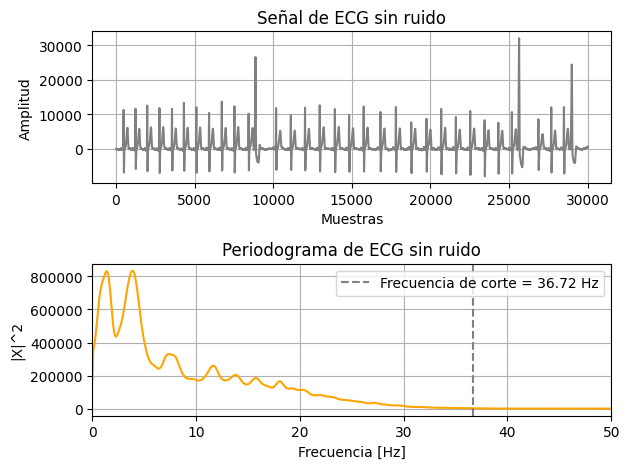

In [3]:
# ------------------------------------------- Lecutra de ECG ------------------------------------------- #


fs_ECG = 1000

# ECG = sio.whosmat ('./ECG_TP4.mat') # devuelve una lista de variables dentro del archivo .mat (MATLAB)
mat_struct = sio.loadmat ('./ECG_TP4.mat')
# print("Variables encontradas en el archivo .mat:", mat_struct.keys()) # esto muestra las variables dentro del archivo .mat (lo miro desde el explorador de variables)

ecg_one_lead = mat_struct ['ecg_lead'] # ECG con ruido

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']


# plt.figure (1)

# plt.subplot (3, 1, 1)
# plt.plot(ecg_one_lead[5000:12000])
# plt.grid (True)
# plt.subplot (3, 1, 2)
# plt.plot(hb_1)
# plt.grid (True)
# plt.subplot (3, 1, 3)
# plt.plot(hb_2)
# plt.grid (True)

# plt.tight_layout()
# plt.show()


# ------------------------------------------- ECG sin ruido ------------------------------------------- #


ECG_sr = np.load ('ecg_sin_ruido.npy') # toma el array que se encuentra en el archivo

N_ECG_sr = len (ECG_sr)

df_ECG_sr = fs_ECG / N_ECG_sr
nn_ECG_sr = np.arange (N_ECG_sr)

promedios_ECG_sr = 12 # parámetro inversamente proporcional a la varianza 
                    # en promedios = 1 tengo algo muy similar a la FFT pelada
                    # se debe ajustar la cantidad de promedios según: 1) mucha varianza, me quedé corto. 2) se corre el centro de masa del espectro, me fui al pasto
nperseg_ECG_sr = N_ECG_sr // promedios_ECG_sr
ff_ECG_sr, per_ECG_sr = sp.welch (ECG_sr, nfft = 5*nperseg_ECG_sr, fs = fs_ECG, nperseg = nperseg_ECG_sr, window = 'flattop') # N/nperseg es la cantidad de promedios que quiero hacer
# normalmente quiero tener un padding de al menos 1000 muestras (tomar con pinzas), en este caso depende de nperseg, ajusto con el parámetro nfft

energia_acum_sr = np.cumsum (per_ECG_sr) # esto devuelve un vector de sumas acumuladas, el area que estoy buscando vendría a ser el último valor
energia_acum_sr_norm = energia_acum_sr / energia_acum_sr[-1] # con [-1] accedo al último valor del vector
corte_ECG_sr = energia_acum_sr_norm[-1] * 0.995
indice_corte_sr = int (np.where (energia_acum_sr_norm >= corte_ECG_sr)[0][0]) # con [0][0] me devuelve el primer valor que cumple con la condición
frec_corte_sr = ff_ECG_sr[indice_corte_sr]


plt.figure (2)

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_sr, ECG_sr, color='gray')
plt.title ("Señal de ECG sin ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_sr, per_ECG_sr, color='orange')
# plt.plot (ff_ECG_sr, 10*np.log10(np.abs(per_ECG_sr))) # representación en dB
plt.axvline (frec_corte_sr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_sr:.2f} Hz')
plt.title ("Periodograma de ECG sin ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 50)

plt.tight_layout()
plt.show()

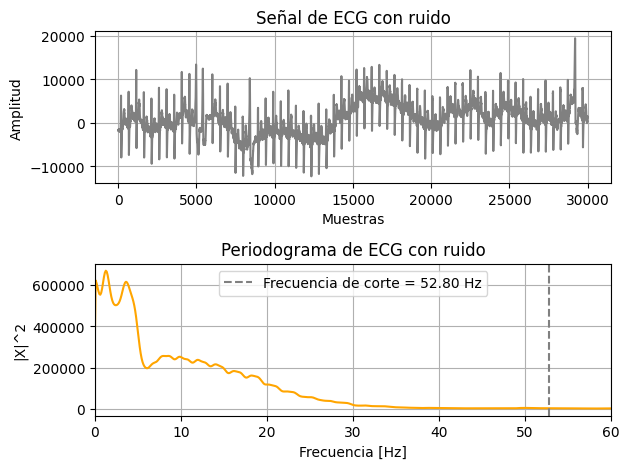

In [4]:
# ------------------------------------------- ECG con ruido ------------------------------------------- #


ECG_cr = ecg_one_lead[670000:700000].ravel()

N_ECG_cr = len (ECG_cr)

df_ECG_cr = fs_ECG / N_ECG_cr
nn_ECG_cr = np.arange (N_ECG_cr)

promedios_ECG_cr = 16
nperseg_ECG_cr = N_ECG_cr // promedios_ECG_cr

ff_ECG_cr, per_ECG_cr = sp.welch (ECG_cr, nfft = 5*nperseg_ECG_cr, fs = fs_ECG, nperseg = nperseg_ECG_cr, window = 'flattop')

energia_acum_cr = np.cumsum (per_ECG_cr)
energia_acum_cr_norm = energia_acum_cr / energia_acum_cr[-1]
corte_ECG_cr = energia_acum_cr_norm[-1] * 0.995
indice_corte_cr = int (np.where (energia_acum_cr_norm >= corte_ECG_cr)[0][0])
frec_corte_cr = ff_ECG_cr[indice_corte_cr]


plt.figure (3)

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_cr, ECG_cr, color='gray')
# plt.plot (ff_ECG_cr, 10*np.log10(np.abs(per_ECG_cr))) # representación en dB
plt.title ("Señal de ECG con ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_cr, per_ECG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_cr:.2f} Hz')
plt.title ("Periodograma de ECG con ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

### *Trabajando con PPG*

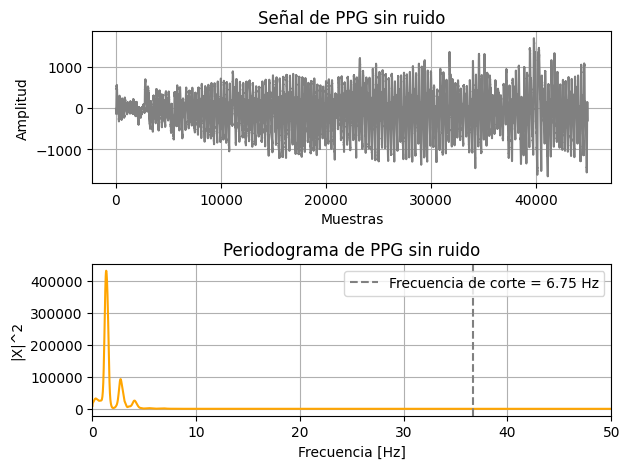

In [5]:
fs_PPG = 400

PPG_sr = np.load('ppg_sin_ruido.npy')

N_PPG_sr = len (PPG_sr)

df_PPG_sr = fs_PPG / N_PPG_sr
nn_PPG_sr = np.arange (N_PPG_sr)

promedios_PPG_sr = 12
nperseg_PPG_sr = N_PPG_sr // promedios_PPG_sr

ff_PPG_sr, per_PPG_sr = sp.welch (PPG_sr, nfft = 5*nperseg_PPG_sr, fs = fs_PPG, nperseg = nperseg_PPG_sr, window = 'flattop')

energia_acum_PPG_sr = np.cumsum (per_PPG_sr)
energia_acum_PPG_sr_norm = energia_acum_PPG_sr / energia_acum_PPG_sr[-1]
corte_PPG_sr = energia_acum_PPG_sr_norm[-1] * 0.995
indice_corte_PPG_sr = int (np.where (energia_acum_PPG_sr_norm >= corte_PPG_sr)[0][0])
frec_corte_PPG_sr = ff_PPG_sr[indice_corte_PPG_sr]

plt.figure (4)

plt.subplot (2, 1, 1)
plt.plot (nn_PPG_sr, PPG_sr, color='gray')
plt.title ("Señal de PPG sin ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_PPG_sr, per_PPG_sr, color='orange')
plt.axvline (frec_corte_sr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_PPG_sr:.2f} Hz')
plt.title ("Periodograma de PPG sin ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 50)

plt.tight_layout()
plt.show()

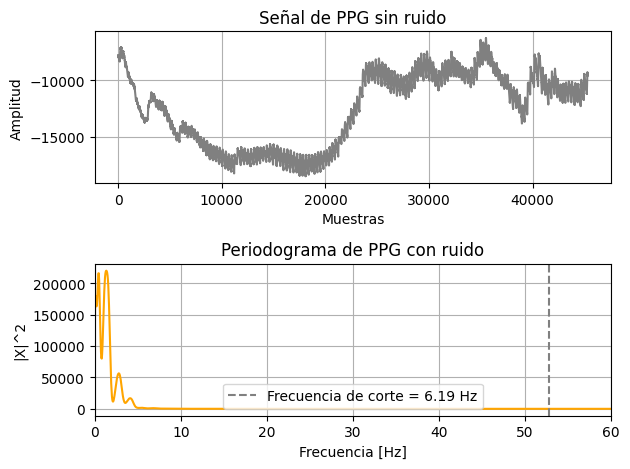

In [6]:
# ------------------------------------------- PPG con ruido ------------------------------------------- #


PPG_cr = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1) # omite la cabecera, si existe

N_PPG_cr = len (PPG_cr)

df_PPG_cr = fs_PPG / N_PPG_cr
nn_PPG_cr = np.arange (N_PPG_cr)

promedios_PPG_cr = 24
nperseg_PPG_cr = N_PPG_cr // promedios_PPG_cr

ff_PPG_cr, per_PPG_cr = sp.welch (PPG_cr, nfft = 5*nperseg_PPG_cr, fs = fs_PPG, nperseg = nperseg_PPG_cr, window = 'flattop')

energia_acum_PPG_cr = np.cumsum (per_PPG_cr)
energia_acum_PPG_cr_norm = energia_acum_PPG_cr / energia_acum_PPG_cr[-1]
corte_PPG_cr = energia_acum_PPG_cr_norm[-1] * 0.995
indice_corte_PPG_cr = int (np.where (energia_acum_PPG_cr_norm >= corte_PPG_cr)[0][0])
frec_corte_PPG_cr = ff_PPG_cr[indice_corte_PPG_cr]

plt.figure (5)

plt.subplot (2, 1, 1)
plt.plot (nn_PPG_cr, PPG_cr, color='gray')
plt.title ("Señal de PPG sin ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_PPG_cr, per_PPG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_PPG_cr:.2f} Hz')
plt.title ("Periodograma de PPG con ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

### *Trabajando con audios*

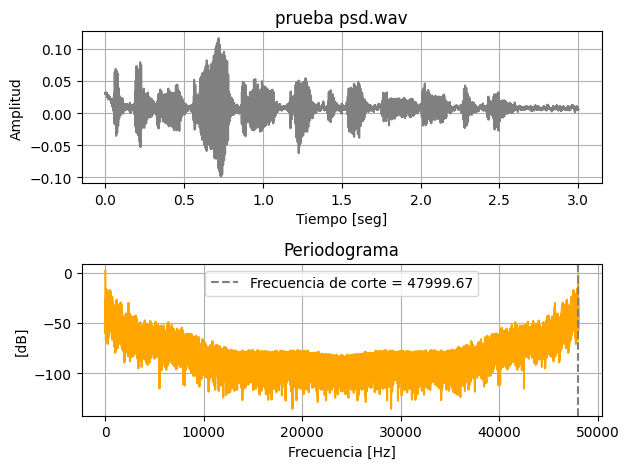

In [10]:
# ------------------------------------------- Lectura de audios ------------------------------------------- #


fs_1, wav_data_1 = sio.wavfile.read ('prueba psd.wav')
fs_2, wav_data_2 = sio.wavfile.read ('silbido.wav')
fs_3, wav_data_3 = sio.wavfile.read ('la cucaracha.wav')

N_1 = len(wav_data_1)
N_2 = len(wav_data_2)
N_3 = len(wav_data_3)

df_1 = fs_1 / N_1
df_2 = fs_2 / N_2
df_3 = fs_3 / N_3

tt_1 = np.arange (0, N_1/fs_1, 1/fs_1)
tt_2 = np.arange (0, N_2/fs_2, 1/fs_2)
tt_3 = np.arange (0, N_3/fs_3, 1/fs_3)

ff_1 = np.arange (N_1) * df_1
ff_2 = np.arange (N_2) * df_2
ff_3 = np.arange (N_3) * df_3


# ------------------------------------------- Audio 1 -> 'prueba psd.wav' ------------------------------------------- #


# Utilizo método del Periodograma Ventaneado
per_audio_1 = np.abs ((fft (wav_data_1 * window.blackman(N_1)))**2) / N_1
per_audio_1_dB = 10*np.log10(per_audio_1)

energia_acum_1 = np.cumsum (per_audio_1)
energia_acum_1_norm = energia_acum_1 / energia_acum_1[-1]
corte_1 = energia_acum_1_norm[-1] * 0.995
indice_corte_1 = (int) (np.where (energia_acum_1_norm >= corte_1)[0][0])
frec_corte_1 = ff_1[indice_corte_1]


plt.figure (6)

plt.subplot (2, 1, 1)
plt.plot (tt_1, wav_data_1, color='gray')
plt.title ('prueba psd.wav')
plt.xlabel ('Tiempo [seg]')
plt.ylabel ('Amplitud')
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_1, per_audio_1_dB, color='orange')
plt.axvline (frec_corte_1, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_1:.2f}')
plt.title ('Periodograma')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
plt.grid (True)
plt.legend ()

plt.tight_layout()
plt.show()

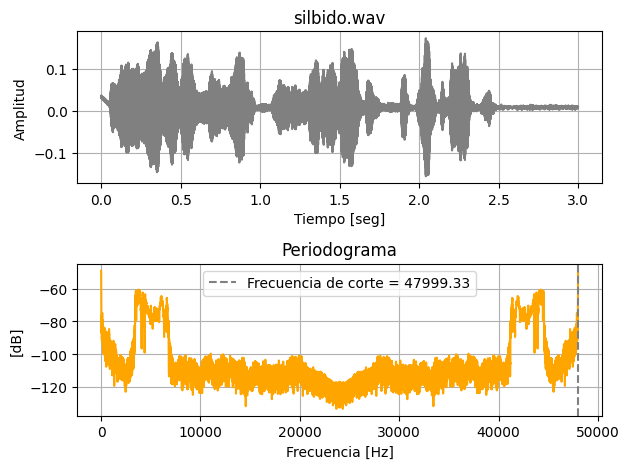

In [8]:
# ------------------------------------------- Audio 2 -> 'silbido.wav' ------------------------------------------- #


# Utilizo método de Blackman-Tukey
per_audio_2 = blackman_tukey (wav_data_2, M = None) / N_2
per_audio_2_dB = 10*np.log10(per_audio_2)

energia_acum_2 = np.cumsum (per_audio_2)
energia_acum_2_norm = energia_acum_2 / energia_acum_2[-1]
corte_2 = energia_acum_2_norm[-1] * 0.995
indice_corte_2 = (int) (np.where (energia_acum_2_norm >= corte_2)[0][0])
frec_corte_2 = ff_2[indice_corte_2]


plt.figure (7)

plt.subplot (2, 1, 1)
plt.plot (tt_2, wav_data_2, color='gray')
plt.title ('silbido.wav')
plt.xlabel ('Tiempo [seg]')
plt.ylabel ('Amplitud')
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_2, per_audio_2_dB, color='orange')
plt.axvline (frec_corte_2, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_2:.2f}')
plt.title ('Periodograma')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
plt.grid (True)
plt.legend ()

plt.tight_layout()
plt.show()

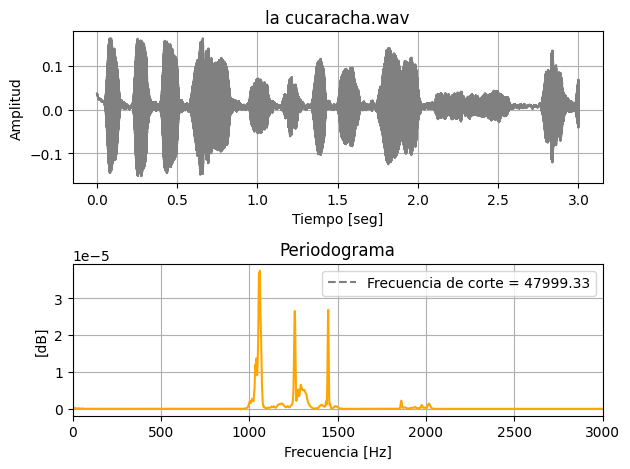

In [9]:
# ------------------------------------------- Audio 3 -> 'la cucaracha.wav' ------------------------------------------- #


# Utilizo método de Welch
promedios_audio_3 = 10 # defino la cantidad de bloques a promediar
nperseg_audio_3 = N_3 // promedios_audio_3
ff_3_welch, per_audio_3 = sp.welch (wav_data_3, nfft = 10*nperseg_audio_3, fs = fs_3, nperseg = nperseg_audio_3, window = 'hann')

energia_acum_3 = np.cumsum (per_audio_3)
energia_acum_3_norm = energia_acum_3 / energia_acum_3[-1]
corte_3 = energia_acum_3_norm[-1] * 0.995
indice_corte_3 = (int) (np.where (energia_acum_3_norm >= corte_3)[0][0])
frec_corte_3 = ff_3[indice_corte_2]


plt.figure (8)

plt.subplot (2, 1, 1)
plt.plot (tt_3, wav_data_3, color='gray')
plt.title ('la cucaracha.wav')
plt.xlabel ('Tiempo [seg]')
plt.ylabel ('Amplitud')
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_3_welch, per_audio_3, color='orange')
plt.axvline (frec_corte_3, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_3:.2f}')
plt.title ('Periodograma')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
plt.xlim (0, 3000)
plt.grid (True)
plt.legend ()

plt.tight_layout()
plt.show()

---

## Conclusiones

A partir del análisis espectral realizado sobre las señales reales de **ECG**, **PPG** y **audio**, se comprobó que los métodos de estimación no paramétricos permiten determinar de forma efectiva el **ancho de banda de trabajo** de cada tipo de señal y observar cómo la energía se distribuye en el dominio frecuencial.

En las señales **electrocardiográficas (ECG)**, tanto en condiciones de ruido como sin él, la energía espectral se concentró principalmente por debajo de los **50 Hz**, en concordancia con lo esperado teóricamente y lo descripto por Holton.  
El uso del método de **Welch**, con una cantidad adecuada de promedios y la ventana *flattop*, permitió reducir la **varianza del estimador** y suavizar la densidad espectral de potencia (PSD), obteniendo una curva estable con una frecuencia de corte de alrededor de **36 – 52 Hz** según el nivel de ruido.  
Se observó que, al aumentar el número de promedios, la PSD pierde resolución pero se gana en estabilidad y en la capacidad de distinguir el rango de frecuencias útiles frente al ruido.

En el caso de las señales **fotopletismográficas (PPG)**, el espectro mostró un contenido energético muy concentrado en bajas frecuencias (entre **0.5 Hz y 7 Hz**), correspondiente a los ritmos cardíacos y sus armónicos.  
El método de Welch nuevamente permitió una estimación más robusta frente al ruido, identificando frecuencias de corte de aproximadamente **6 Hz**.  
Al agregar ruido a la señal se verificó un aumento del **piso espectral** y una leve extensión del ancho de banda aparente, fenómeno mitigado mediante la aplicación de ventanas adecuadas y un mayor número de promedios.  
Esto confirma que el método de Welch es particularmente apropiado para **señales biológicas contaminadas con ruido**.

Por otra parte, en las señales **de audio** se compararon tres enfoques distintos:

- El **periodograma ventaneado** (aplicado a `prueba_psd.wav`) mostró una **alta resolución** pero con gran **varianza**, y lóbulos laterales visibles debido al truncamiento temporal de la señal.  
- El método de **Blackman–Tukey** (aplicado a `silbido.wav`) proporcionó un espectro mucho más **suavizado**, representando correctamente la **envolvente espectral** y reduciendo picos exagerados, aunque con menor resolución.  
- Finalmente, el método de **Welch** (aplicado a `la_cucaracha.wav`) entregó un espectro limpio, con buena atenuación del ruido y una estimación estable del **ancho de banda efectivo**, evidenciando el compromiso entre suavizado y resolución frecuencial.

En conjunto, los resultados confirman las propiedades teóricas de cada método:

| Método | Resolución | Varianza | Observaciones |
|:-------|:------------|:----------|:---------------|
| **Periodograma** | Alta | Alta | Sensible al ruido y fuga espectral |
| **Welch** | Media | Baja | Buen compromiso entre varianza y resolución espectral |
| **Blackman–Tukey** | Baja | Muy baja | Suaviza el espectro, depende del truncamiento M |

El cálculo de la **energía acumulada** permitió determinar la **frecuencia de corte $ f_c $** de cada señal, definida como aquella que contiene el **99.5% de la energía total**:

\begin{equation}
E(f_c) = 0.995 \, E_\text{tot}
\end{equation}

De esta manera se obtuvo el **ancho de banda efectivo** para cada tipo de señal:
- ECG: entre **40 – 50 Hz**,  
- PPG: entre **5 – 7 Hz**,  
- Audio: del orden de **decenas de kHz**, dependiendo del contenido armónico.

En síntesis, el trabajo demostró la utilidad práctica de los métodos de estimación espectral no paramétricos en el análisis de señales reales.  
El método de **Welch** se destacó por ofrecer el mejor equilibrio entre **resolución** y **varianza**, permitiendo identificar con precisión el rango de frecuencias relevantes, incluso en presencia de ruido, y evidenciando las **características espectrales distintivas** de cada tipo de señal.